## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = utils.calibrate_camera(images)

## Calibrate the camera and undistort the image

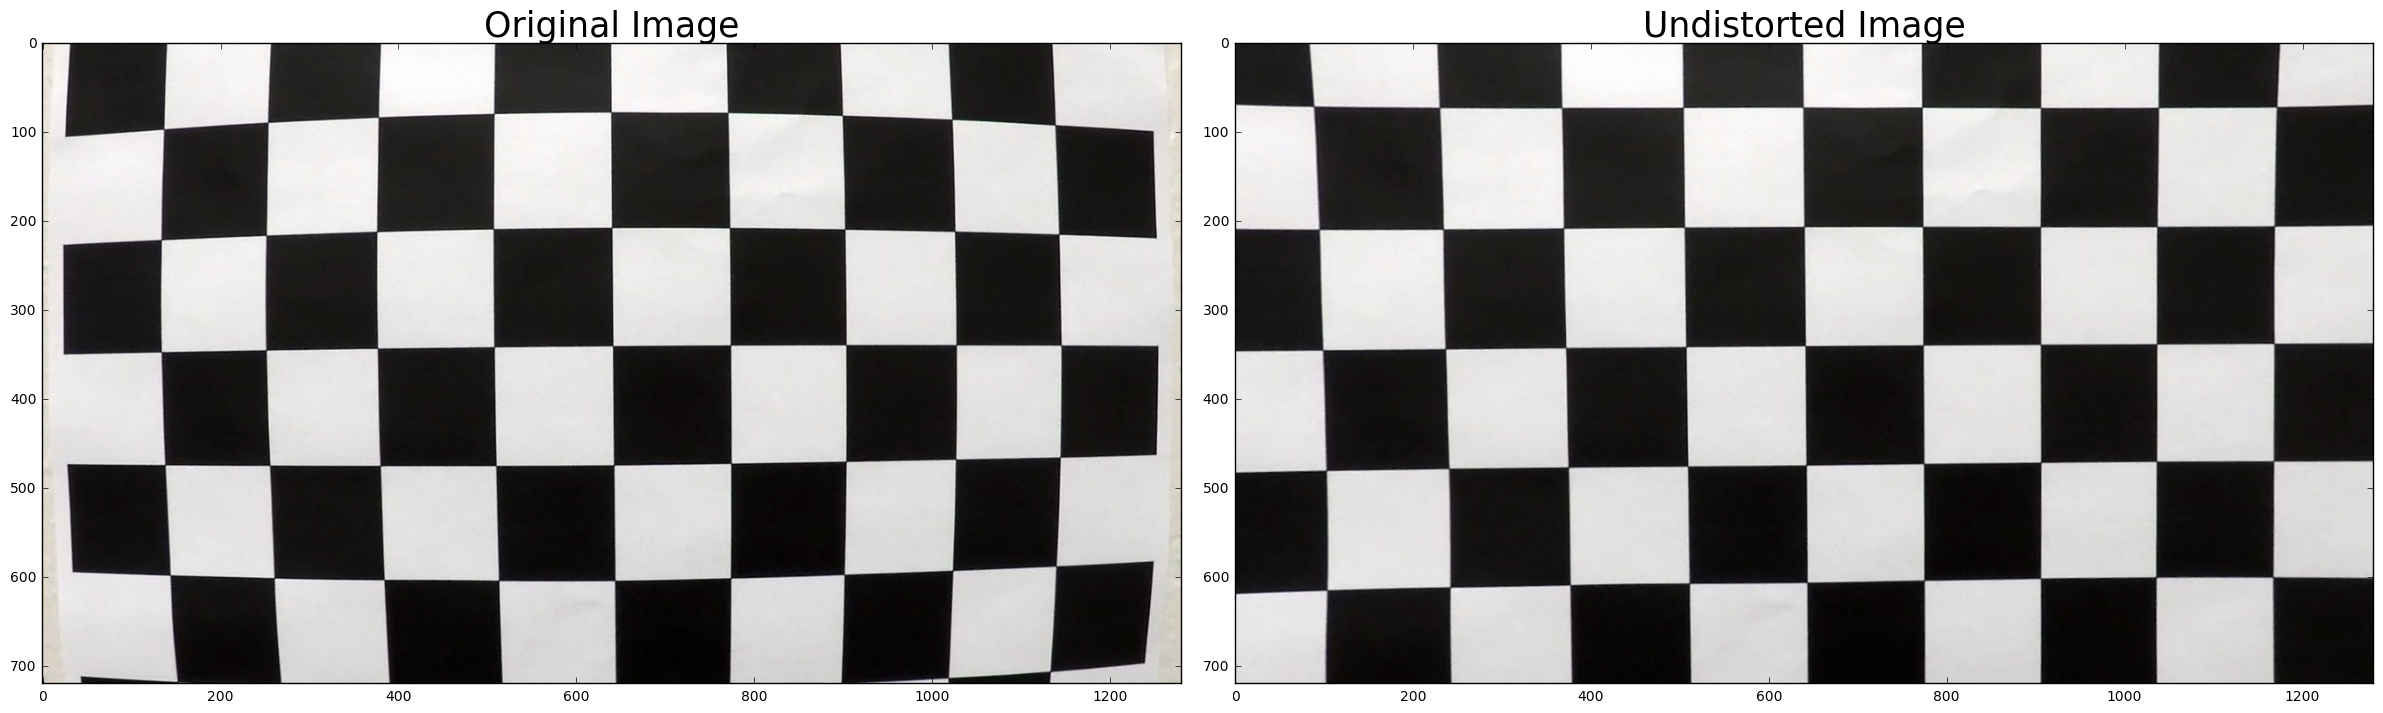

In [3]:
#generate the image correction matrix
img = utils.load_image('./camera_cal/calibration1.jpg')

dst = utils.undistort(img, mtx, dist)

f, (axis1, axis2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
axis1.imshow(img)
axis1.set_title('Original Image', fontsize=25)
axis2.imshow(dst)
axis2.set_title('Undistorted Image', fontsize=25)

In [4]:
def draw_region_of_interest(img, region, color=[255,0,0]):
    left_top = tuple(region[0])
    left_bottom = tuple(region[1])
    right_bottom = tuple(region[2])
    right_top = tuple(region[3])

    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)

Test the perespective transformation on a straight road segment

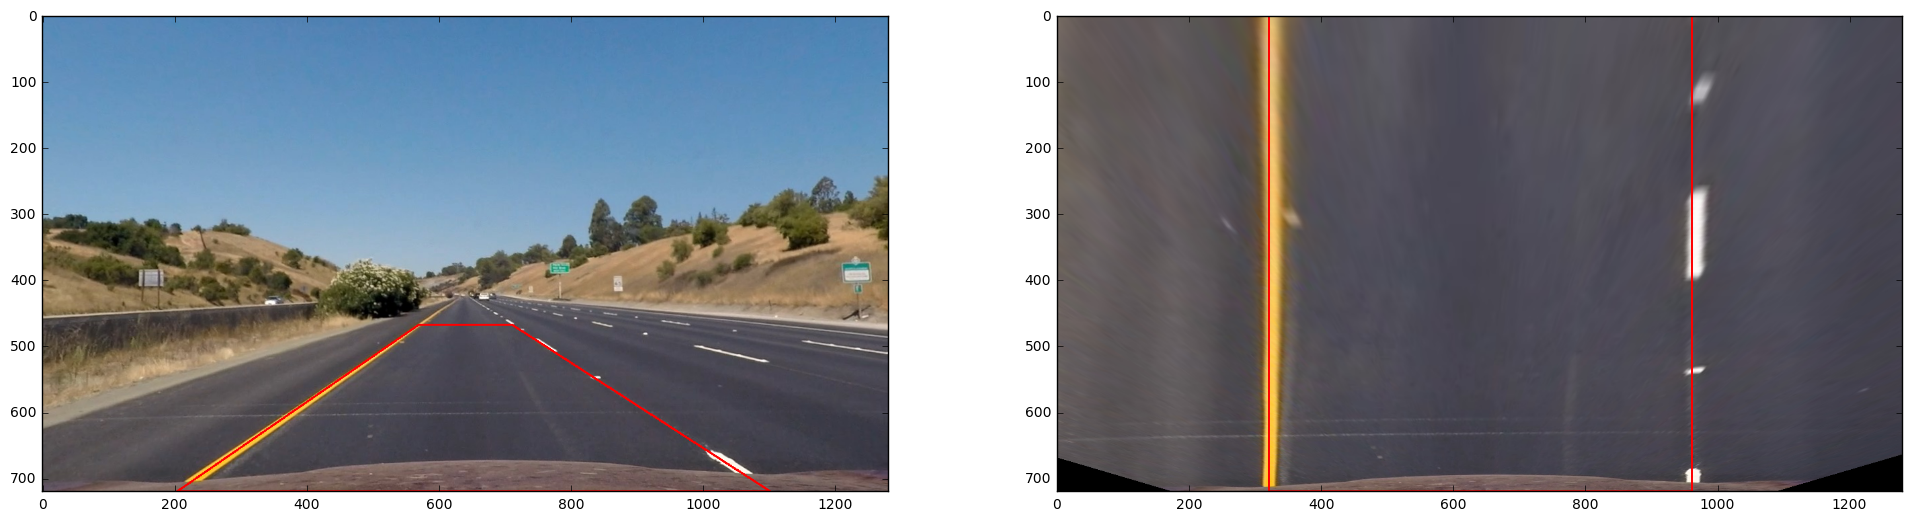

In [132]:
img = utils.load_image('./test_images/straight_lines1.jpg')
img = utils.undistort(img, mtx, dist)

img_top, src, dest = utils.convert_to_birds_eye_view(img)
draw_region_of_interest(img, src)
draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(img_top)

In [126]:
def get_yellow(warped):
    rgb = utils.color_threshold(warped, 'H', (0, 40))
    rgb = rgb & utils.color_threshold(warped, 'S', (100,255)) 
    rgb = rgb & utils.color_threshold(warped, 'V', (200,255))
    return rgb

def get_white(warped):
    rgb = utils.color_threshold(warped, 'R', (120, 255))
    rgb = rgb & utils.color_threshold(warped, 'G', (120,255)) 
    rgb = rgb & utils.color_threshold(warped, 'B', (180,155))
    return rgb

def detect_white_line(image):
    lb = np.array([120, 120, 180])
    ub = np.array([255, 255, 255])
    line = cv2.inRange(image, lb, ub)
    binary = np.zeros(image.shape[0:2])
    binary[(line > 0)] = 1

    return binary

def detect_yellow_line(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lb = np.array([ 0, 100, 200])
    ub = np.array([ 40, 255, 255])
    line   = cv2.inRange(image, lb, ub)
    binary = np.zeros(image.shape[0:2])
    binary[(line > 0)] = 1

    return binary


def pipeline(img, mtx, dist):
    warped = utils.undistort(img, mtx, dist)
    
    # Threshold x gradient
    y_sobel = utils.abs_sobel_threshold(warped,'y', 5, thresh=(170, 200))
    x_sobel = utils.abs_sobel_threshold(warped,'x', 5, thresh=(30, 170))
    
    saturation = utils.color_threshold(warped,'S', (150, 220))
    
    yellow = detect_yellow_line(warped)
    white = detect_white_line(warped)
    
    
    # Threshold color channel
    
    combined_binary = np.zeros_like(x_sobel)
    
    combined_binary[(white==1) | (yellow==1)] = 1
    #return combined_binary

    #combined_binary[(x_sobel == 1) | (saturation==1) | (y_sobel==1)] = 1
    
    #return combined_binary

    #convert to birds eye view
    res, src, dst = utils.convert_to_birds_eye_view(combined_binary)
        
    return res

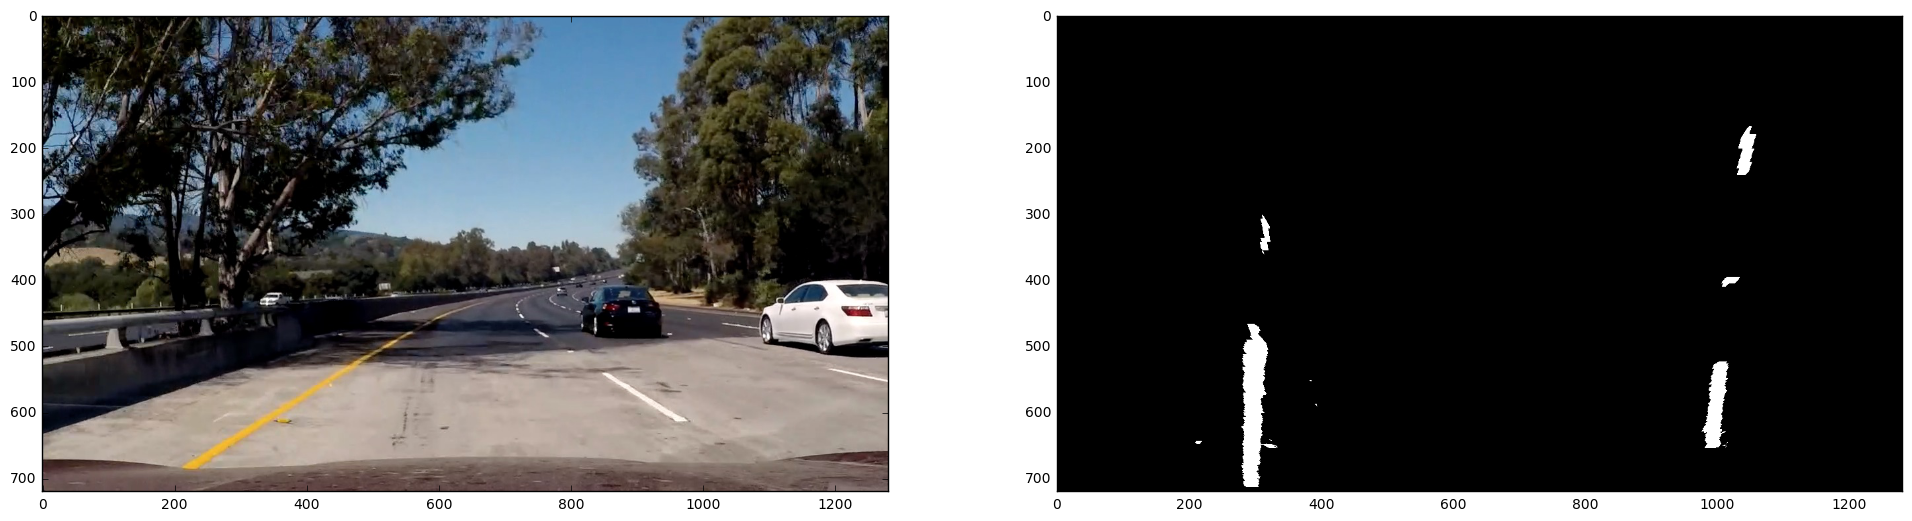

In [127]:
img = utils.load_image('./test_images/test5.jpg')
#img = cv2.flip(img, 1)

res = pipeline(img, mtx, dist)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(res, cmap='gray')

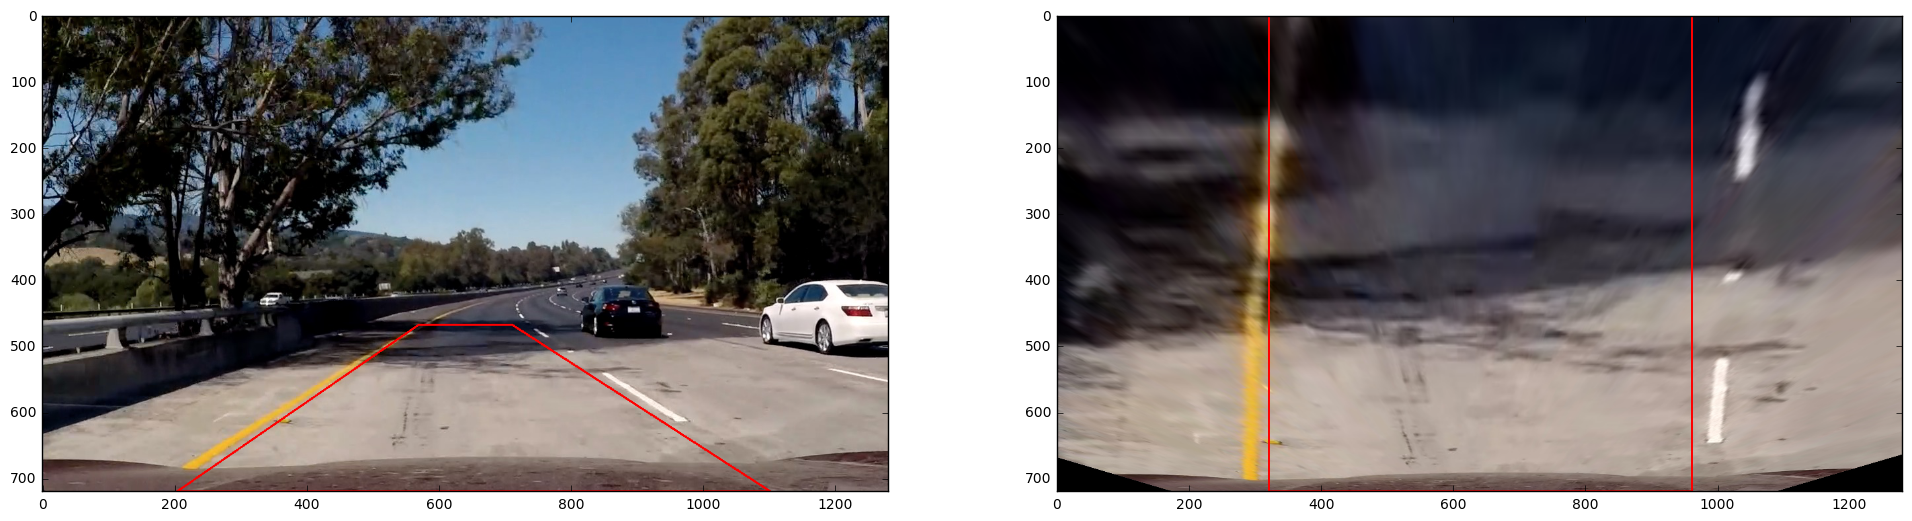

In [128]:
img_top, src, dest = utils.convert_to_birds_eye_view(img)
draw_region_of_interest(img, src)
draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(img_top)

/home/miro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


(720, 0)

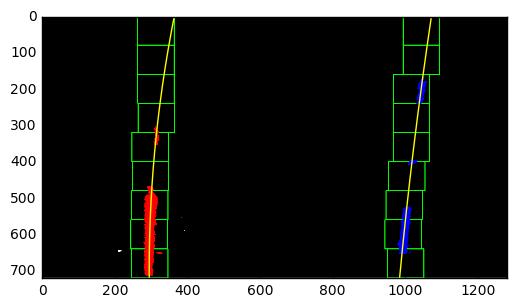

In [129]:
binary_warped = res
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Find the peak of the left and right halves of the histogram
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [130]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

(720, 0)

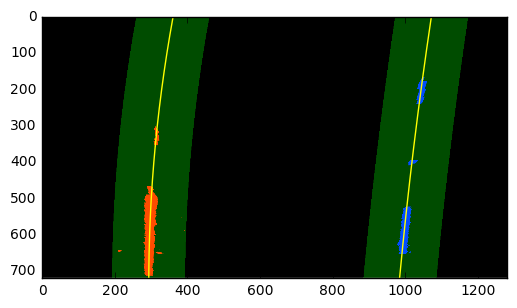

In [131]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([fit_leftx-margin, fity]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_leftx+margin, fity])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([fit_rightx-margin, fity]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_rightx+margin, fity])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)